26 26


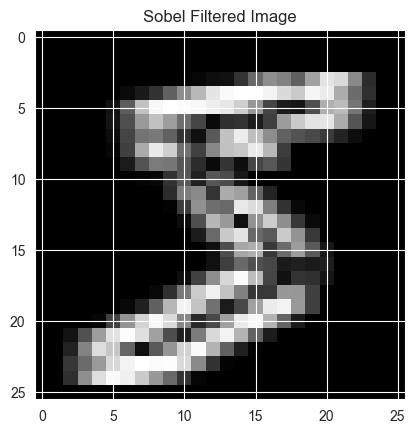

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Load MNIST dataset
def load_mnist():
    mnist = fetch_openml('mnist_784', version=1)
    images = mnist.data.to_numpy().reshape(-1, 28, 28)  # Reshape to 28x28
    labels = mnist.target.astype(int).to_numpy()
    return images, labels

images, labels = load_mnist()
# print(images.shape, labels.shape)
# Define Convolution Function
def convolve(image, kernel):
    kernel_height, kernel_width = kernel.shape
    img_height, img_width = image.shape
    output = np.zeros((img_height - kernel_height + 1, img_width - kernel_width + 1))

    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            output[i, j] = np.sum(image[i:i + kernel_height, j:j + kernel_width] * kernel)

    return output

# Sobel Filter Function
def sobel_filter(image):
    sobel_x = np.array([[1, 0, -1], [-2, 0, 2], [1, 0, -1]])
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    gx = convolve(image, sobel_x)
    gy = convolve(image, sobel_y)

    print(len(gx), len(gy))
    return np.sqrt(gx**2 + gy**2)

# Apply Sobel filter to an example image and visualize
example_image = images[0]
filtered_image = sobel_filter(example_image)

plt.imshow(filtered_image, cmap='gray')
plt.title("Sobel Filtered Image")
plt.show()


In [2]:
from skimage.feature import hog
def calculate_hog_features(image):
    gradient = sobel_filter(image)
    print(len(gradient))
    # Simulated HOG processing
    hog_features = gradient.flatten()  # Simplified: flattening for representation
    return hog_features

# Example HOG Feature Extraction
hog_features = calculate_hog_features(example_image)
print("HOG Feature Vector Length:", len(hog_features))


26
HOG Feature Vector Length: 676


In [3]:
from sklearn.decomposition import PCA

def center_images(images):
    mean_image = np.mean(images, axis=0)
    centered_images = images - mean_image
    return centered_images

def apply_pca(images, n_components):
    pca = PCA(n_components=n_components)
    transformed_images = pca.fit_transform(images)
    return transformed_images, pca

# Center and apply PCA to the dataset
centered_images = center_images(images.reshape(-1, 784))  # Flatten images for PCA
pca_transformed_images, pca_model = apply_pca(centered_images, n_components=50)

print("PCA-transformed shape:", pca_transformed_images.shape)


PCA-transformed shape: (70000, 50)


In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

def tune_decision_tree(train_data, train_labels):
    param_grid = {'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10]}
    dt = DecisionTreeClassifier()
    grid_search = GridSearchCV(dt, param_grid, cv=5)
    grid_search.fit(train_data, train_labels)
    return grid_search.best_estimator_

# Split dataset into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(pca_transformed_images, labels, test_size=0.2, random_state=42)

# Train with hyperparameter tuning
best_dt_model = tune_decision_tree(train_data, train_labels)
print("Best Decision Tree Parameters:", best_dt_model.get_params())


Best Decision Tree Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

def train_svm(train_data, train_labels):
    svm = SVC(kernel='linear', C=1.0)
    svm.fit(train_data, train_labels)
    return svm

# Train the SVM model
svm_model = train_svm(train_data, train_labels)

# Evaluate and compare the Decision Tree and SVM models
def evaluate_model(model, test_data, test_labels, model_name):
    predictions = model.predict(test_data)
    print(f"{model_name} Classification Report:\n", classification_report(test_labels, predictions))

evaluate_model(best_dt_model, test_data, test_labels, "Decision Tree")
evaluate_model(svm_model, test_data, test_labels, "SVM")


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Generate and plot confusion matrix for Decision Tree
dt_predictions = best_dt_model.predict(test_data)
plot_confusion_matrix(test_labels, dt_predictions)

# Generate and plot confusion matrix for SVM
svm_predictions = svm_model.predict(test_data)
plot_confusion_matrix(test_labels, svm_predictions)


In [ ]:
def prune_tree(train_data, train_labels):
    pruned_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=5)
    pruned_tree.fit(train_data, train_labels)
    return pruned_tree

# Prune the Decision Tree
pruned_dt_model = prune_tree(train_data, train_labels)

# Evaluate the pruned model
evaluate_model(pruned_dt_model, test_data, test_labels, "Pruned Decision Tree")


=== Overfitted Model Results ===
Training Accuracy: 1.00
Testing Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


=== Pruned Model Results ===
Training Accuracy: 0.95
Testing Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



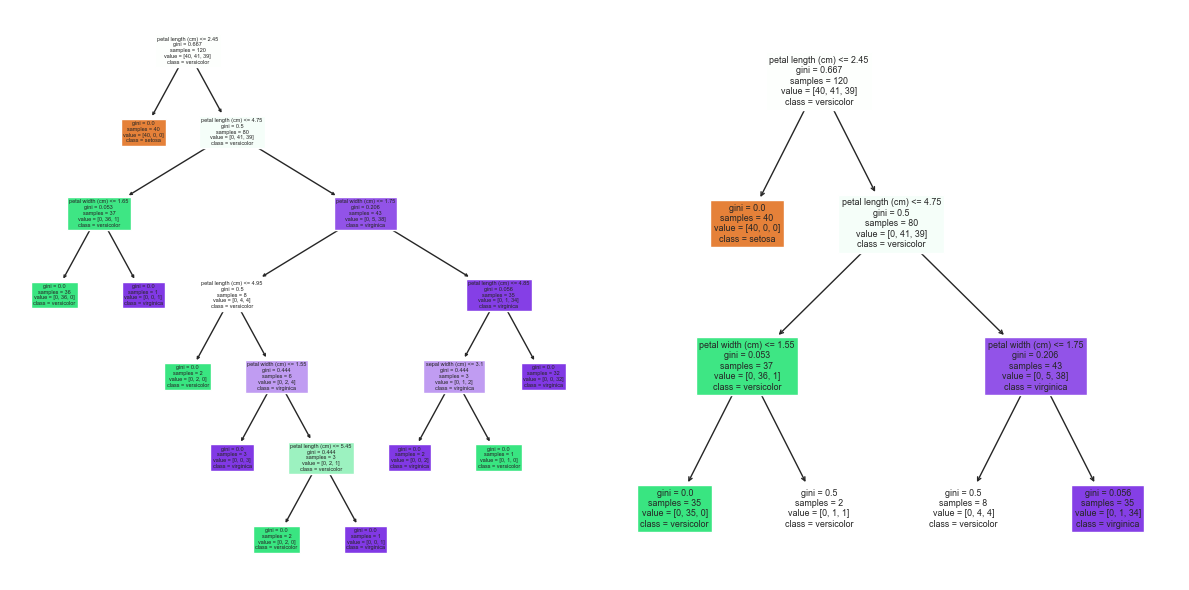

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Load dataset
data = load_iris()
X = data.data
y = data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Create an overfitted decision tree model
overfit_clf = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=42)
overfit_clf.fit(X_train, y_train)

# Make predictions with the overfitted model
y_train_pred_overfit = overfit_clf.predict(X_train)
y_test_pred_overfit = overfit_clf.predict(X_test)

# Evaluate the overfitted model
train_accuracy_overfit = accuracy_score(y_train, y_train_pred_overfit)
test_accuracy_overfit = accuracy_score(y_test, y_test_pred_overfit)

print("=== Overfitted Model Results ===")
print(f"Training Accuracy: {train_accuracy_overfit:.2f}")
print(f"Testing Accuracy: {test_accuracy_overfit:.2f}")
print(classification_report(y_test, y_test_pred_overfit))

# Step 2: Resolve overfitting with pre-pruning
pruned_clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=5, random_state=42)
pruned_clf.fit(X_train, y_train)

# Make predictions with the pruned model
y_train_pred_pruned = pruned_clf.predict(X_train)
y_test_pred_pruned = pruned_clf.predict(X_test)

# Evaluate the pruned model
train_accuracy_pruned = accuracy_score(y_train, y_train_pred_pruned)
test_accuracy_pruned = accuracy_score(y_test, y_test_pred_pruned)

print("\n=== Pruned Model Results ===")
print(f"Training Accuracy: {train_accuracy_pruned:.2f}")
print(f"Testing Accuracy: {test_accuracy_pruned:.2f}")
print(classification_report(y_test, y_test_pred_pruned))

# Visualize both trees
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Overfitted Decision Tree")
plot_tree(overfit_clf, filled=True, feature_names=data.feature_names, class_names=data.target_names)

plt.subplot(1, 2, 2)
plt.title("Pruned Decision Tree")
plot_tree(pruned_clf, filled=True, feature_names=data.feature_names, class_names=data.target_names)

plt.tight_layout()
plt.show()
